In [ ]:
#@title Installation & imports
!pip3 install -U umap-learn > /dev/null

import os
from pathlib import Path

import numpy as np
import umap.umap_ as umap
import h5py

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pandas as pd
import matplotlib as mpl

import torch as tr
!pip install umap-learn > /dev/null
import umap
!pip install py7zr > /dev/null
import requests
import os
import zipfile
import py7zr
import warnings
warnings.filterwarnings('ignore')

# Utils

In [ ]:
fam = set({
    "tmRNA",
    "16s",
    "23s",
    "grp1",
    "telomerase",
    "RNaseP",
    "srp",
    "tRNA",
    "5s"
})

rnafm_emb_name = 'rnafm'
rinalmo_emb_name = 'RiNALMo'
rnaernie_emb_name = 'RNAErnie'
rnabert_emb_name = 'rnabert'
rnamsm_emb_name = 'rna-msm'
ernierna_emb_name = 'ERNIE-RNA'
one_hot_emb_name = 'one-hot'


def download_embedding(emb_name):
  response = requests.get(f'https://zenodo.org/records/13821093/files/{emb_name}_ArchiveII.7z?download=1', stream=True)
  response.raise_for_status()

  temp_dir = os.path.join(os.getcwd(), "temp")
  os.makedirs(temp_dir, exist_ok=True)

  temp_7z_file = os.path.join(temp_dir, "temp.7z")
  with open(temp_7z_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
      if chunk:
        f.write(chunk)

  with py7zr.SevenZipFile(temp_7z_file, "r") as zip_ref:
      zip_ref.extractall(os.getcwd())

  os.remove(temp_7z_file)
  os.rmdir(temp_dir)
  return h5py.File(f"{emb_name}_ArchiveII.h5", "r")

def get_umap_proj(id_to_embedding_seq):
  any_embedding = id_to_embedding_seq['tmRNA_Yers.pest._AE017042_1-364'][()]
  n = len(id_to_embedding_seq.keys())
  d = any_embedding.shape[1]
  average_embeddings = np.zeros((n, d))
  for i, entry in enumerate(id_to_embedding_seq.items()):
      seqid, embedding = entry
      numpy_embedding = embedding[()]
      average_embeddings[i] =  np.mean(numpy_embedding, axis=0)
  umap_model = umap.UMAP(random_state=42, n_components=3)
  return umap_model.fit_transform(average_embeddings)


In [ ]:
rinalmo_id_to_embedding_seq = download_embedding(rinalmo_emb_name)
ernierna_id_to_embedding_seq = download_embedding(ernierna_emb_name)
one_hot_id_to_embedding_seq = download_embedding(one_hot_emb_name)
rnabert_id_to_embedding_seq = download_embedding(rnabert_emb_name)
rnafm_id_to_embedding_seq = download_embedding(rnafm_emb_name)
rnaernie_id_to_embedding_seq = download_embedding(rnaernie_emb_name)
rnamsm_id_to_embedding_seq = download_embedding(rnamsm_emb_name)

In [ ]:
# Extract family name from sequence ID
def get_family_name(sequence_id):
    return sequence_id.split('_')[0]

# Extract sequence IDs for each point
sequence_ids = one_hot_id_to_embedding_seq.keys()

# Extract family names for each sequence ID
family_names = [get_family_name(sequence_id) for sequence_id in sequence_ids]
unique_families = ['23s', 'telomerase', '16s', 'grp1', 'tmRNA', 'RNaseP', 'tRNA', 'srp', '5s']
colors = mpl.colormaps['Set1'].colors
colors_ordered = [colors[2] + (1,), colors[3] + (1,), colors[1]+ (1,), colors[4]+ (.5,), colors[0]+ (.5,), colors[5]+ (.5,), colors[7]+ (.1,), colors[6]+ (.1,), colors[8]+ (.1,)]
zs = [20, 18, 16, 14, 12, 10, 8, 6, 4]
alphas = [1, 1, 1, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2]
family_colors = {family: color for family, color in zip(unique_families, colors_ordered)}
family_markers = {family: marker for family, marker in zip(unique_families, [".", "x", "d", "^", ".", "x", "d", "^", "."])}
family_zs = {family: z for family, z in zip(unique_families, zs)}
family_alphas = {family: alpha for family, alpha in zip(unique_families, alphas)}
zs = [family_zs[family] for family in family_names]
alphas = [family_alphas[family] for family in family_names]
markers = ["." for family in family_names]
order = np.argsort(zs)

In [ ]:
llm_names = {
    "rna-msm": "RNA-MSM",
    "rnafm": "RNA-FM",
    "rnabert": "RNABERT",
}

In [ ]:
rinalmo_proj = get_umap_proj(rinalmo_id_to_embedding_seq)
ernierna_proj = get_umap_proj(ernierna_id_to_embedding_seq)
one_hot_proj = get_umap_proj(one_hot_id_to_embedding_seq)
rnabert_proj = get_umap_proj(rnabert_id_to_embedding_seq)
rnafm_proj = get_umap_proj(rnafm_id_to_embedding_seq)
rnaernie_proj = get_umap_proj(rnaernie_id_to_embedding_seq)
rnamsm_proj = get_umap_proj(rnamsm_id_to_embedding_seq)

In [ ]:
def plot_embedding(data_points, emb_name, f, colors, unique_families, zs, ax):

  # markers
  #plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
  #fig = plt.figure()
  #ax=fig.add_subplot(projection='3d')
  # Hide grid lines
  ax.grid(False)

  ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.set_axis_off()
  ax.set_ylim(-6.91, 24.93)
  ax.set_xlim(-9.18, 23.48)
  ax.set_zlim(-12.39, 23.63)
  vleng = 22

  i = np.array([vleng, 0, 0])
  j = np.array([0, vleng, 0])
  k = np.array([0, 0, vleng])

  p = np.array([vleng, 0, vleng])
  q = np.array([0, vleng, vleng])
  r = np.array([vleng, vleng, 0])

  ax_color = '0.8'
  ax.plot(*np.vstack([[0,0,0], i]).T, color=ax_color)
  ax.plot(*np.vstack([[0,0,0], j]).T, color=ax_color)
  ax.plot(*np.vstack([[0,0,0], k]).T, color=ax_color)
  ax.plot(*np.vstack([[0,0,vleng], p]).T, color=ax_color)
  ax.plot(*np.vstack([[0,0,vleng], q]).T, color=ax_color)
  ax.plot(*np.vstack([[vleng,0,0], r]).T, color=ax_color)
  ax.plot(*np.vstack([[0,vleng,0], r]).T, color=ax_color)
  ax.plot(*np.vstack([[0,vleng,0], q]).T, color=ax_color)
  ax.plot(*np.vstack([[vleng,0,0], p]).T, color=ax_color)

  ax.view_init(22, 25)
  order = np.argsort(zs)

  colors = mpl.colormaps['Set1'].colors
  colors_ordered = [colors[2] + (1,), colors[3] + (1,), colors[1]+ (1,), colors[4]+ (.5,), colors[0]+ (.5,), colors[5]+ (.5,), colors[7]+ (.1,), colors[6]+ (.1,), colors[8]+ (.1,)]
  zs = [20, 18, 16, 14, 12, 10, 8, 6, 4]
  alphas = [1, 1, 1, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2]
  family_colors = {family: color for family, color in zip(unique_families, colors_ordered)}

  if f !='ALL':
    for family in unique_families:
      if family != f:
        family_colors[family] = (0.8, 0.8, 0.8, 0.005)
    colors = [family_colors[family] for family in family_names]
  else:
    family_markers = {family: marker for family, marker in zip(unique_families, [".", "x", "d", "^", ".", "x", "d", "^", "."])}
    family_zs = {family: z for family, z in zip(unique_families, zs)}
    family_alphas = {family: alpha for family, alpha in zip(unique_families, alphas)}
    zs = [family_zs[family] for family in family_names]
    alphas = [family_alphas[family] for family in family_names]
    markers = ["." for family in family_names]
    order = np.argsort(zs)

    colors = [family_colors[family] for family in family_names]

  sc = ax.scatter(data_points[:, 0][order], data_points[:, 1][order], data_points[:, 2][order], c=[colors[i] for i in order])
  plt.title(f'{llm_names.get(emb_name, emb_name)}')
  plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

# UMAP projections

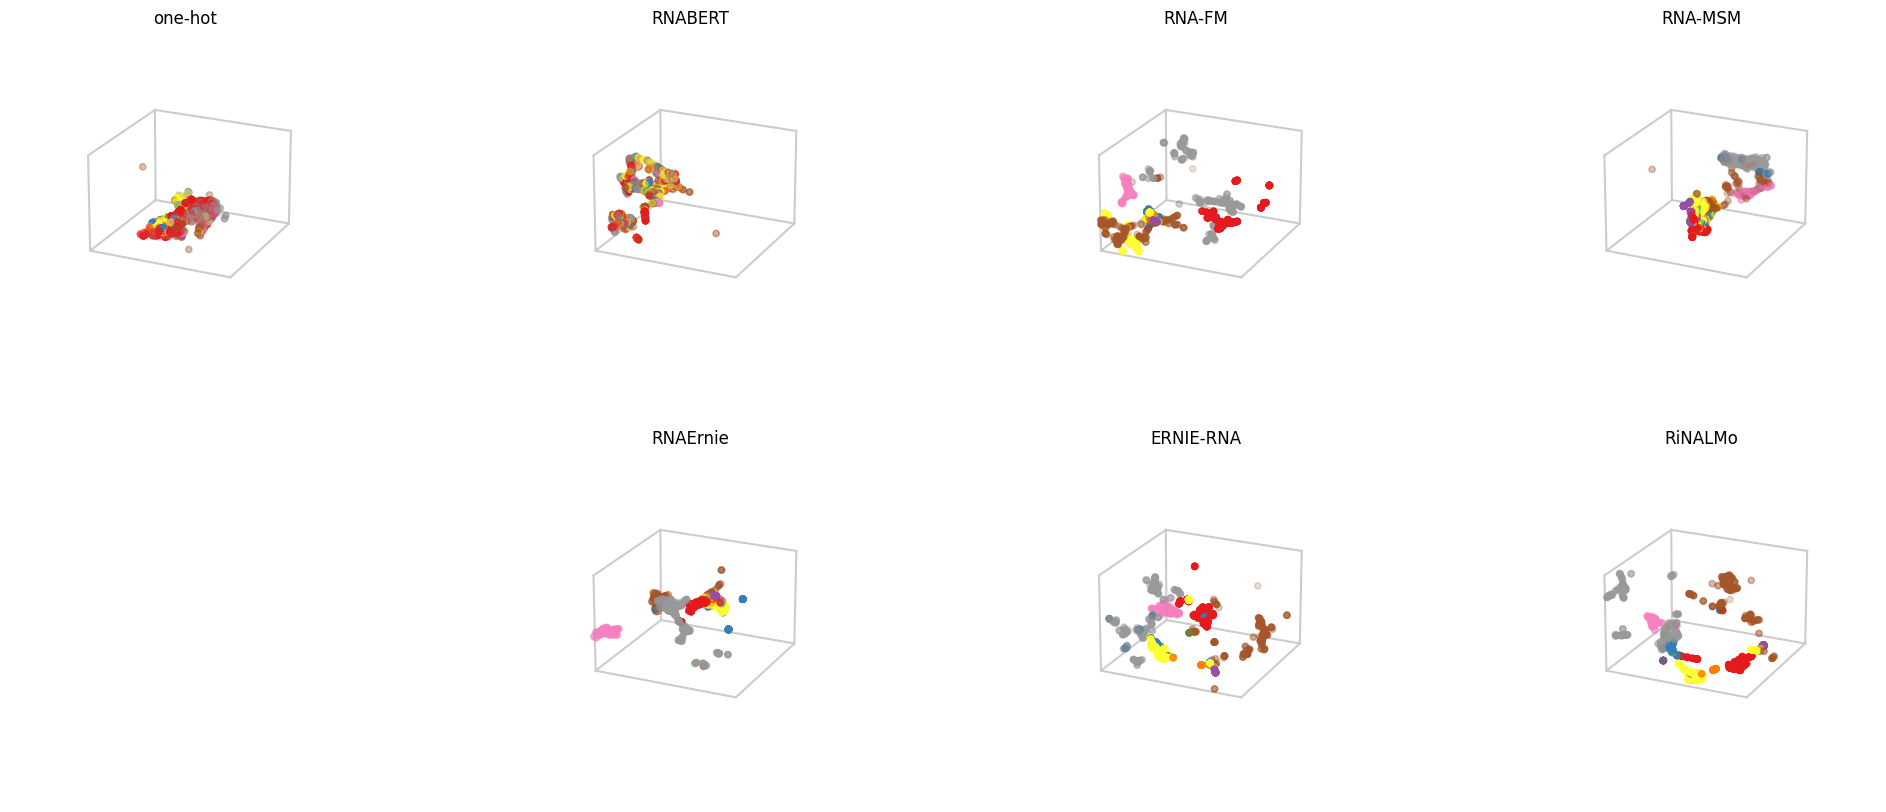

In [ ]:
#@title Visualize projections with a given family { run: "auto" }
#@markdown Select family to be highlighted in the embeddings.

#@markdown ---
fam_name = 'ALL' #@param ["ALL","tmRNA","16s","23s","grp1","telomerase","RNaseP","srp","tRNA","5s"]
#@markdown ---

fig = plt.figure(figsize=(25, 10))
ax1=fig.add_subplot(241, projection='3d')
plot_embedding(one_hot_proj, one_hot_emb_name, fam_name, colors, unique_families, zs, ax1)

ax2=fig.add_subplot(242,projection='3d')
plot_embedding(rnabert_proj, rnabert_emb_name, fam_name, colors, unique_families, zs, ax2)

ax3=fig.add_subplot(243, projection='3d')
plot_embedding(rnafm_proj, rnafm_emb_name, fam_name, colors, unique_families, zs, ax3)

ax4=fig.add_subplot(244,projection='3d')
plot_embedding(rnamsm_proj, rnamsm_emb_name, fam_name, colors, unique_families, zs, ax4)

ax5=fig.add_subplot(246, projection='3d')
plot_embedding(rnaernie_proj, rnaernie_emb_name, fam_name, colors, unique_families, zs, ax5)

ax6=fig.add_subplot(247,projection='3d')
plot_embedding(ernierna_proj, ernierna_emb_name, fam_name, colors, unique_families, zs, ax6)

ax7=fig.add_subplot(248,projection='3d')
plot_embedding(rinalmo_proj, rinalmo_emb_name, fam_name, colors, unique_families, zs, ax7)